In [39]:
using LinearAlgebra
using PyPlot
import TensorCrossInterpolation as TCI
using QuanticsTCI

include("honeycomb.jl")
include("kanemele.jl")
include("latticeplot.jl")
include("berry.jl")
include("chern.jl")

function displaymatrix(A::Matrix)
    show(stdout, "text/plain", A)
end

function maxlinkdim(n::Integer, localdim::Integer=2)
    return 0:n-2, [min(localdim^i, localdim^(n - i)) for i in 1:(n-1)]
end

maxlinkdim (generic function with 2 methods)

# Honeycomb lattice

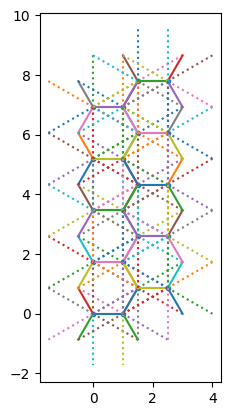

In [3]:
q = 5
B = 4pi / sqrt(3) / q

lattice = honeycomblattice(0, 1, 0, q - 1)

fig, ax = subplots()

sitesplot = collect(zip(realspacecoordinates.(lattice.fromint)...))
ax.plot(sitesplot..., ".")
ax.set_aspect(1)

for s in lattice.fromint
    for n in neighbours(s)
        ax.plot(collect(zip(realspacecoordinates.([s, n])...))...)
    end

    for n in nextneighbours(s)
        ax.plot(collect(zip(realspacecoordinates.([s, n])...))..., ":")
    end
end


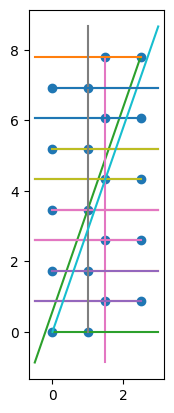

In [4]:
fig, ax = subplots()

sitesplot = collect(zip(realspacecoordinates.(lattice.fromint)...))
ax.plot(sitesplot..., "o")
ax.set_aspect(1)

for s in lattice.fromint
    for n in neighbours(s)
        norig = realspacecoordinates(n)
        nmap = realspacecoordinates(reducesite(n, 1, q))
        ax.plot([norig[1], nmap[1]], [norig[2], nmap[2]])
    end
end

# Hamiltonian

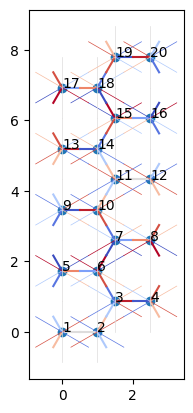

In [5]:
cm = get_cmap("coolwarm")

fig, ax = subplots()

sitesplot = collect(zip(realspacecoordinates.(lattice.fromint)...))
ax.plot(sitesplot..., "o")
ax.set_aspect(1)

for (i, rs) in enumerate(realspacecoordinates.(lattice.fromint))
    ax.annotate(i, xy=rs)
end

phimatrix = zeros(ComplexF64, 4q, 4q)
for (i, s) in enumerate(lattice.fromint)

    for n in neighbours(s)
        phi = peierls(B, s, n)
        rs, rn = realspacecoordinates.([s, n])
        midpoint = (rs + rn) / 2
        ax.plot([rs[1], midpoint[1]], [rs[2], midpoint[2]], color=cm(0.5 * imag(exp(1im * phi)) + 0.5))
    end

    for n in nextneighbours(s)
        phi = peierls(B, s, n)
        phiinv = peierls(B, n, s)

        rs, rn = realspacecoordinates.([s, n])
        midpoint = (rs + rn) / 2
        ax.plot([rs[1], midpoint[1]], [rs[2], midpoint[2]], linewidth=0.5, color=cm(0.5 * imag(exp(1im * phi)) + 0.5))
        phimatrix[i, TCI.pos(lattice, reducesite(n, 1, q))] += exp(1im * phi)
    end
end

In [6]:
Ht = get_Ht(q, [pi / 2, 3], lattice)
#displaymatrix(Ht[:, 1, :, 1])
print("\nHt is hermitian: $([Ht[:, a, :, b] ≈ adjoint(Ht[:, a, :, b]) for a in 1:2, b in 1:2])")


Ht is hermitian: Bool[1 1; 1 1]

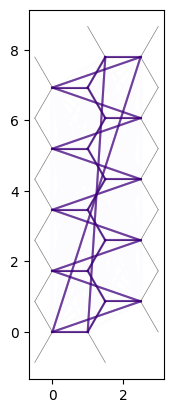

In [7]:
fig, ax = subplots()
displayhamiltonian(ax, abs.(Ht[:, 1, :, 1]), lattice)

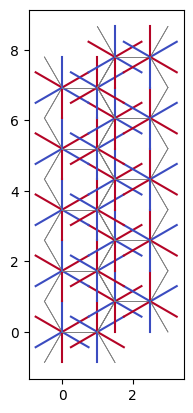

In [8]:
cm = get_cmap("coolwarm")

fig, ax = subplots()
ax.set_aspect(1)

for s in lattice.fromint
    for n in neighbours(s)
        for nn in neighbours(n)
            rs, rn, rnn = realspacecoordinates.([s, n, nn])
            ax.plot([rs[1], rn[1]], [rs[2], rn[2]], color="gray", linewidth=0.5)

            value = sign(antisymmetricproduct(rn - rs, rnn - rn))
            midpoint = (rs + rnn) / 2
            ax.plot([rs[1], midpoint[1]], [rs[2], midpoint[2]], color=cm((1 + value) / 2))
        end
    end
end


Hlambda is hermitian: Bool[1 1; 1 1]


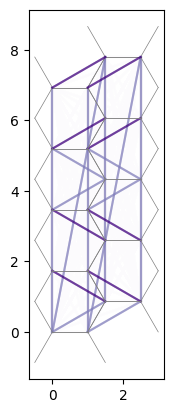

In [9]:
Hlambda = get_Hlambda(q, [0.0, 0.0], lattice)

fig, ax = subplots()
ax.set_aspect(1)
displayhamiltonian(ax, abs.(Hlambda[:, 1, :, 1]), lattice)

println("\nHlambda is hermitian: $([Hlambda[:, a, :, b] ≈ adjoint(Hlambda[:, a, :, b]) for a in 1:2, b in 1:2])")

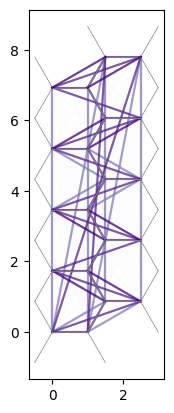

In [10]:
H = get_H(q, 0.6, [0.0, 0.0], lattice)

fig, ax = subplots()
ax.set_aspect(1)
displayhamiltonian(ax, abs.(H[:, 1, :, 1]), lattice)

# Band structure

/Users/Ritter.Marc/.pyenv/versions/3.8.15/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


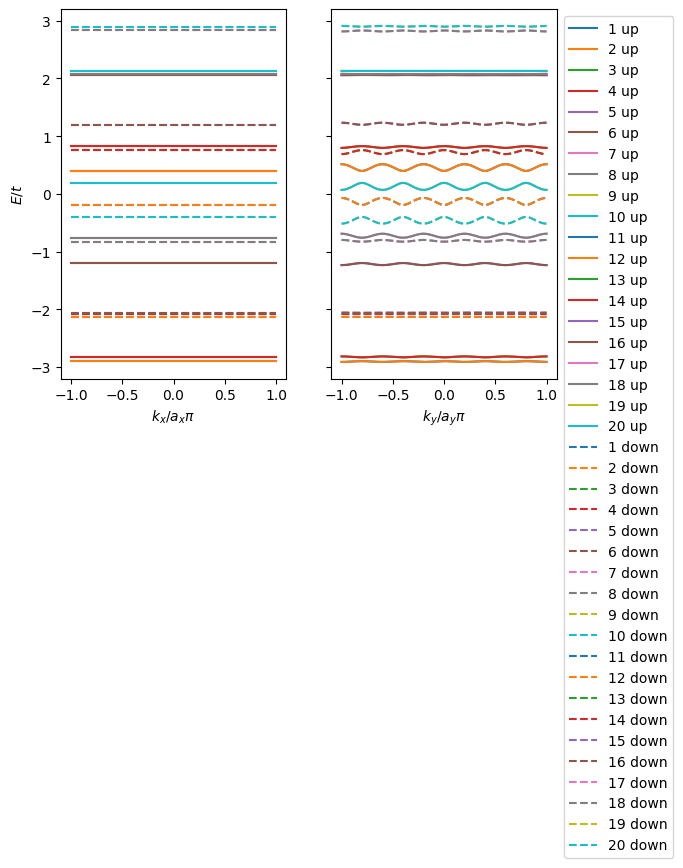

PyObject <matplotlib.legend.Legend object at 0x2a3df0b80>

In [11]:
function bands(q, lambdaSO, kx, ky)
    H = get_H(q, lambdaSO, [kx, ky], lattice)
    return eigvals(H[:, 1, :, 1]), eigvals(H[:, 2, :, 2])
end

lambdaSO = 0.2 #/ (3 * sqrt(3))

BZedgex = pi / 1.5
kxvals = range(-BZedgex, BZedgex; length=301)
BZedgey = pi / sqrt(3)
kyvals = range(-BZedgey, BZedgey; length=301)

fig, axs = subplots(ncols=2, sharey=true)

bandsx = bands.(q, lambdaSO, kxvals, 0)

axs[1].plot(kxvals / BZedgex, [b[1] for b in bandsx], "-", label=["$i up" for i in eachindex(bandsx[1][1])])
axs[1].plot(kxvals / BZedgex, [b[2] for b in bandsx], "--", label=["$i down" for i in eachindex(bandsx[1][2])])

bandsy = bands.(q, lambdaSO, 0, kyvals)
axs[2].plot(kyvals / BZedgey, [b[1] for b in bandsy], "-", label=["$i up" for i in eachindex(bandsy[1][1])])
axs[2].plot(kyvals / BZedgey, [b[2] for b in bandsy], "--", label=["$i down" for i in eachindex(bandsy[1][2])])

axs[1].set_xlabel(L"$k_x/a_x\pi$")
axs[2].set_xlabel(L"$k_y/a_y\pi$")
axs[1].set_ylabel(L"$E/t$")
axs[2].legend(loc="upper left", bbox_to_anchor=(1, 1))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


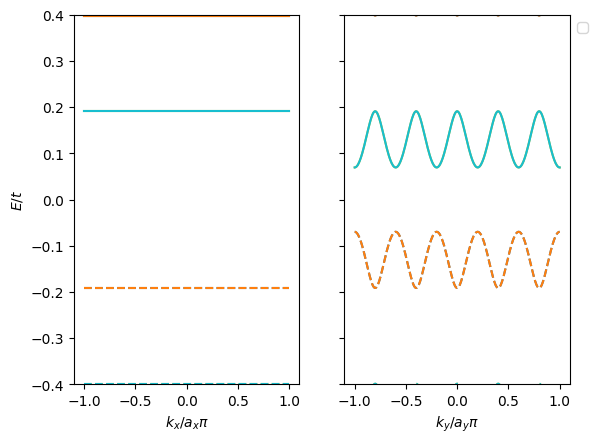

PyObject <matplotlib.legend.Legend object at 0x2a3ffc820>

In [12]:
fig, axs = subplots(ncols=2, sharey=true)

bandsx = bands.(q, lambdaSO, kxvals, 0)
axs[1].plot(kxvals / BZedgex, [b[1] for b in bandsx], "-")
axs[1].plot(kxvals / BZedgex, [b[2] for b in bandsx], "--")

bandsy = bands.(q, lambdaSO, 0, kyvals)
axs[2].plot(kyvals / BZedgey, [b[1] for b in bandsy], "-")
axs[2].plot(kyvals / BZedgey, [b[2] for b in bandsy], "--")

axs[1].set_xlabel(L"$k_x/a_x\pi$")
axs[2].set_xlabel(L"$k_y/a_y\pi$")
axs[1].set_ylabel(L"$E/t$")
axs[1].set_ylim(-0.4, 0.4)
axs[2].set_ylim(-0.4, 0.4)
axs[2].legend(loc="upper left", bbox_to_anchor=(1, 1))

# Eigenstates

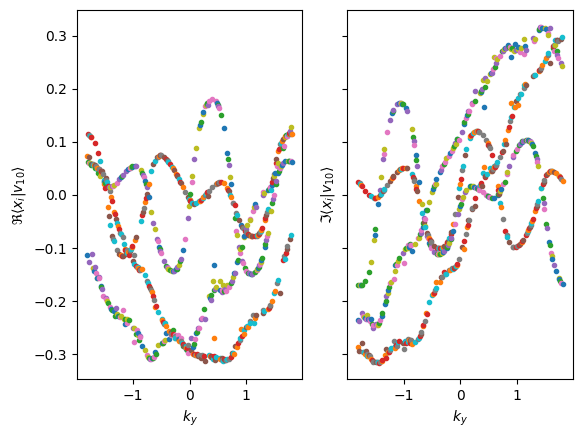

PyObject Text(337.03156565656565, 0.5, '$\\Im\\langle x_i | v_{10} \\rangle$')

In [13]:
function getstate(H, n=1:8q)
    values, vectors = eigen(H[:, 1, :, 1])
    ev = values[n]
    indices = filter(i -> any(values[i] .≈ ev), eachindex(values))
    return vectors[indices]
end

n = 10
states = [getstate(get_H(q, lambdaSO, [0, ky], lattice), [n])[:] for ky in kyvals]

fig, axs = subplots(ncols=2, sharey=true)
for (ky, a) in zip(kyvals, states)
    axs[1].plot([ky], [real.(a)], ".")
    axs[2].plot([ky], [imag.(a)], ".")
end

axs[1].set_xlabel(L"$k_y$")
axs[1].set_ylabel("\$\\Re\\langle x_i | v_{$n} \\rangle\$")
axs[2].set_xlabel(L"$k_y$")
axs[2].set_ylabel("\$\\Im\\langle x_i | v_{$n} \\rangle\$")

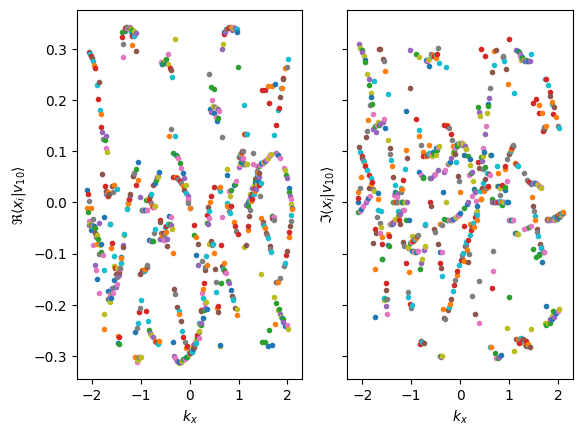

PyObject Text(337.03156565656565, 0.5, '$\\Im\\langle x_i | v_{10} \\rangle$')

In [14]:
states = [getstate(get_H(q, lambdaSO, [kx, 0], lattice), [n])[:] for kx in kxvals]

fig, axs = subplots(ncols=2, sharey=true)
for (kx, a) in zip(kxvals, states)
    axs[1].plot([kx], [real.(a)], ".")
    axs[2].plot([kx], [imag.(a)], ".")
end

axs[1].set_xlabel(L"$k_x$")
axs[1].set_ylabel("\$\\Re\\langle x_i | v_{$n} \\rangle\$")
axs[2].set_xlabel(L"$k_x$")
axs[2].set_ylabel("\$\\Im\\langle x_i | v_{$n} \\rangle\$")

# Berry curvature

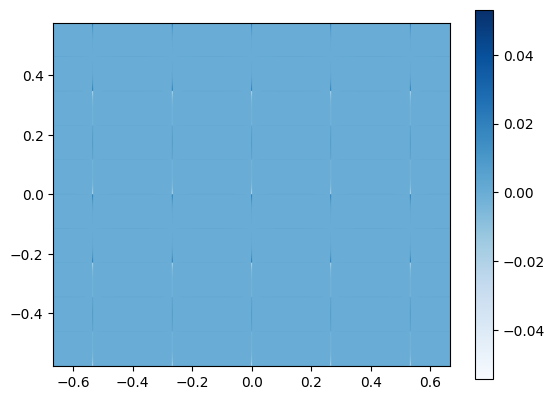

PyObject <matplotlib.colorbar.Colorbar object at 0x298419f70>

In [60]:
nquantics = 10
ndiscretization = 2^nquantics

BZedgex = pi / 1.5
kxvals = range(-BZedgex, BZedgex; length=ndiscretization)
BZedgey = pi / sqrt(3)
kyvals = range(-BZedgey, BZedgey; length=ndiscretization)

ϵ = [BZedgex, BZedgey] ./ ndiscretization

Hcached = TCI.CachedFunction{Array{Int},Matrix{ComplexF64}}(
    kindex -> get_H(q, lambdaSO, [kxvals[kindex[1]], kyvals[kindex[2]]] .+ ϵ, lattice)[:, 1, :, 1]
)

H = [Hcached([kxi, kyi]) for kxi in 1:ndiscretization, kyi in 1:ndiscretization]
A = berrycurvature_dets(H, n)
imshow(A, cmap="Blues", extent=([-BZedgex, BZedgex, -BZedgey, BZedgey] ./ pi)) |> colorbar

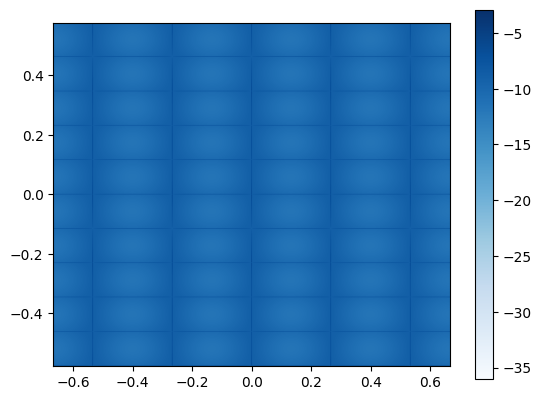

PyObject <matplotlib.colorbar.Colorbar object at 0x2904b1580>

In [61]:
fig, ax = subplots()
ax.imshow(log.(abs.(A)), cmap="Blues", extent=([-BZedgex, BZedgex, -BZedgey, BZedgey] ./ pi)) |> colorbar

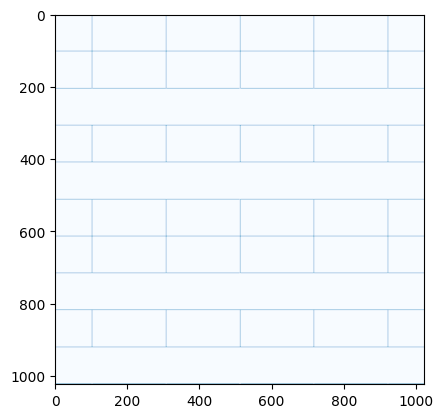

PyObject <matplotlib.image.AxesImage object at 0x298511400>

In [62]:
imshow(sign.(A), cmap="Blues")

## Band structure in 2d

Compare Berry curvature

In [63]:
band2d = [real(bands(q, lambdaSO, kx, ky)[1][n]) for kx in kxvals, ky in kyvals]

1024×1024 Matrix{Float64}:
 0.0696336  0.069657   0.0697273  …  0.0697273  0.069657   0.0696336
 0.072695   0.0727182  0.0727879     0.0727879  0.0727182  0.072695
 0.0757735  0.0757965  0.0758655     0.0758655  0.0757965  0.0757735
 0.0788671  0.0788899  0.0789583     0.0789583  0.0788899  0.0788671
 0.081974   0.0819966  0.0820644     0.0820644  0.0819966  0.081974
 0.0850924  0.0851148  0.085182   …  0.085182   0.0851148  0.0850924
 0.0882202  0.0882424  0.088309      0.088309   0.0882424  0.0882202
 0.0913556  0.0913776  0.0914437     0.0914437  0.0913776  0.0913556
 0.0944965  0.0945183  0.0945839     0.0945839  0.0945183  0.0944965
 0.0976409  0.0976626  0.0977276     0.0977276  0.0976626  0.0976409
 0.100787   0.100808   0.100873   …  0.100873   0.100808   0.100787
 0.103932   0.103953   0.104017      0.104017   0.103953   0.103932
 0.107074   0.107095   0.107159      0.107159   0.107095   0.107074
 ⋮                                ⋱                        
 0.103932   0.103953 

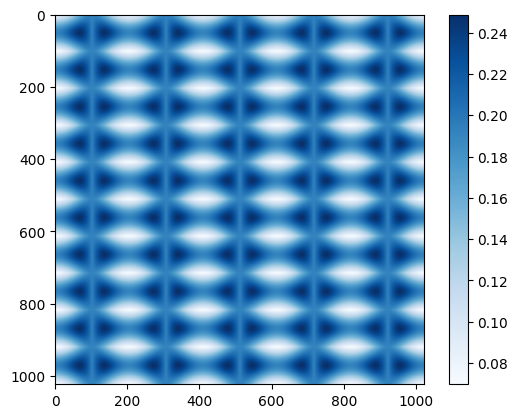

PyObject <matplotlib.colorbar.Colorbar object at 0x2985aabb0>

In [64]:
imshow(band2d, cmap="Blues") |> colorbar

# Chern number through conventional sum

In [65]:
sum(A) / 2pi

6.785183320455502e-15

# Quantics TCI rep of Berry curvature

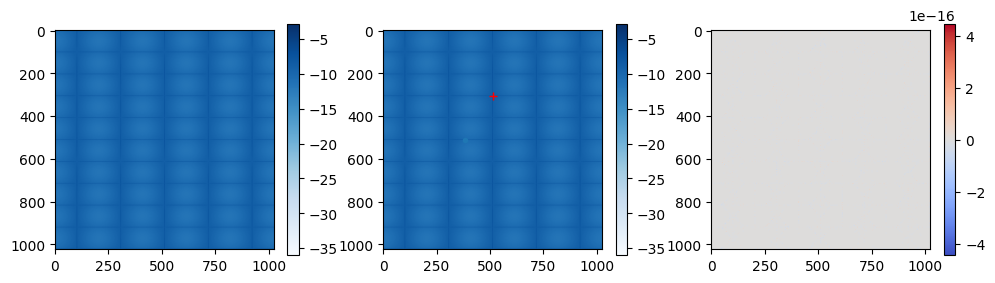

PyObject <matplotlib.colorbar.Colorbar object at 0x29878fa30>

In [66]:
f(q) = berrycurvature_quantics(Hcached, n, q, nquantics)

firstpivot = TCI.optfirstpivot(f, fill(4, nquantics))

fig, axs = subplots(ncols=3, figsize=(12, 3))
axs[1].imshow(log.(abs.(A)), cmap="Blues") |> colorbar

quanticsdata = [
    f(index_to_quantics([kxi, kyi], nquantics))
    for kxi in 1:ndiscretization, kyi in 1:ndiscretization
]

axs[2].imshow(log.(abs.(quanticsdata)), cmap="Blues") |> colorbar
axs[2].plot(quantics_to_index(firstpivot, d=2)..., ".")
axs[2].plot(Tuple(argmax(log.(abs.(A))))..., "r+")

axs[3].imshow(quanticsdata .- A, cmap="coolwarm") |> colorbar

In [67]:
tci, ranks, errors = TCI.crossinterpolate(
    f,
    fill(4, nquantics),
    firstpivot,
    tolerance=1e-12,
    maxiter=200,
)

(TensorCI{Float64} with ranks 200, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  191, 192, 193, 194, 195, 196, 197, 198, 199, 200], [1.9481963938382538, 5.1578889805893064, 3.9101783296156807, 0.886394269057447, 2.362918655963357, 3.7828313420254545, 1.2146058575346865, 0.5721484062257817, 0.31455155211717034, 0.2628461530329484  …  1.0097434977695939e-5, 9.450645089374382e-6, 8.905457708981195e-6, 8.598658197567973e-6, 8.119454071898196e-6, 7.955918998090105e-6, 7.671838745892318e-6, 7.377000855853206e-6, 7.279236458007204e-6, 9.218569690041312e-6])

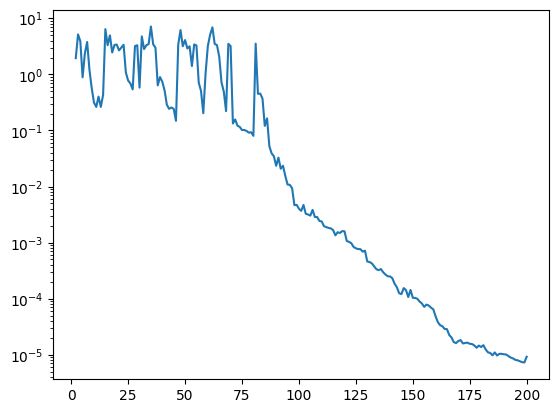

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2a710e850>

In [68]:
semilogy(ranks, errors)

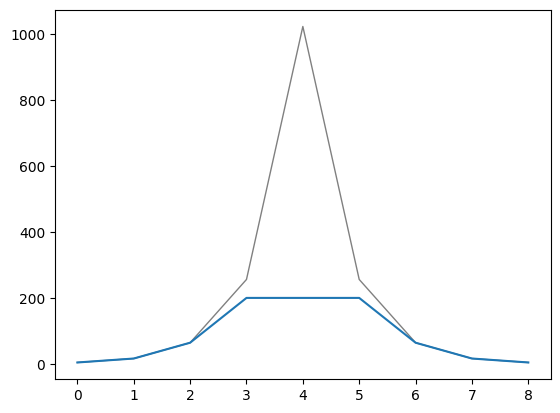

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2a733f160>

In [69]:
plot(maxlinkdim(nquantics, 4)..., color="gray", linewidth=1)
plot(TCI.linkdims(tci))

In [70]:
function scalar(a::Matrix)
    if size(a) == (1, 1)
        return first(a)
    else
        throw(ArgumentError("$a is not a scalar."))
    end
end

function evaluate_qtt(qtt, q::Vector{<:Integer})
    return scalar(prod(T[:, i, :] for (T, i) in zip(qtt, q)))
end

qtt = TCI.tensortrain(tci)
qttdata = [
    evaluate_qtt(qtt, index_to_quantics([kxi, kyi], nquantics))
    for kxi in eachindex(kxvals), kyi in eachindex(kyvals)
]

1024×1024 Matrix{Float64}:
 -3.75431e-12   0.000438853   0.000438491  …   0.000438853   0.000438974
  1.14976e-12  -2.91008e-5   -2.91374e-5      -2.9101e-5    -2.90846e-5
 -2.39257e-8   -2.80202e-5   -2.80549e-5      -2.80191e-5   -2.80046e-5
  1.14198e-13  -2.69819e-5   -2.70151e-5      -2.69808e-5   -2.69679e-5
 -4.60352e-14  -2.59844e-5   -2.60166e-5      -2.59847e-5   -2.59731e-5
 -1.33829e-13  -2.50264e-5   -2.50579e-5   …  -2.50293e-5   -2.50187e-5
 -5.08229e-14  -2.41173e-5   -2.41579e-5      -2.41185e-5   -2.41097e-5
 -1.54419e-13  -2.32486e-5   -2.32793e-5      -2.32497e-5   -2.32412e-5
  1.41239e-14  -2.24246e-5   -2.24547e-5      -2.24225e-5   -2.24144e-5
 -1.47006e-8   -2.16344e-5   -2.16643e-5      -2.16305e-5   -2.16227e-5
 -4.8434e-14   -2.08766e-5   -2.09065e-5   …  -2.08725e-5   -2.08649e-5
 -1.24684e-14  -2.015e-5     -2.01801e-5      -2.01472e-5   -2.01397e-5
  4.64958e-14  -1.94567e-5   -1.94911e-5      -1.94605e-5   -1.94502e-5
  ⋮                                 

vmin = max(min(minimum.([plottransform2.(A), plottransform2.(qttdata)])...), -35) = -35.0
vmax = max(maximum.([plottransform2.(A), plottransform2.(qttdata)])...) = -2.913703486519824


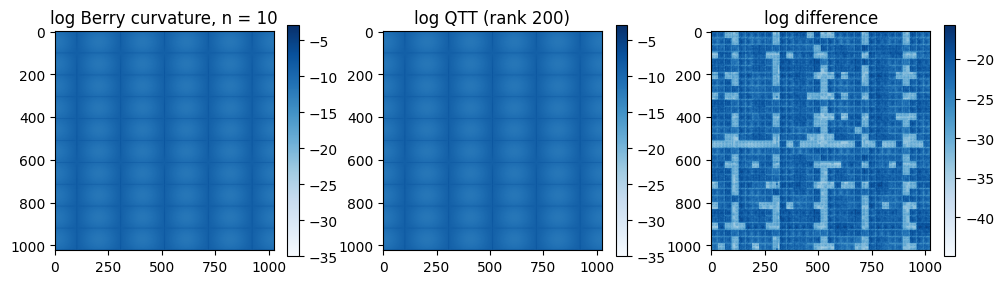

PyObject Text(0.5, 1.0, 'log difference')

In [71]:
plottransform2(x) = log(abs(x))

@show vmin = max(
    min(minimum.([plottransform2.(A), plottransform2.(qttdata)])...),
    -35)
@show vmax = max(maximum.([plottransform2.(A), plottransform2.(qttdata)])...)


fig, axs = subplots(ncols=3, figsize=(12, 3))
axs[1].imshow(plottransform2.(A), cmap="Blues", vmin=vmin, vmax=vmax) |> colorbar
axs[2].imshow(plottransform2.(qttdata), cmap="Blues", vmin=vmin, vmax=vmax) |> colorbar
axs[3].imshow(plottransform2.(qttdata .- A), cmap="Blues") |> colorbar

axs[1].set_title("log Berry curvature, n = $n")
axs[2].set_title("log QTT (rank $(TCI.rank(tci)))")
axs[3].set_title("log difference")

In [72]:
function sumqtt(qtt)
    return prod(sum(T, dims=2)[:, 1, :] for T in qtt)[1]
end

sumqtt(qtt) / 2pi, sum(qttdata) / 2pi, sum(A) / 2pi

(-4.409653476469844e-5, -4.403712400193552e-5, 6.785183320455502e-15)

Comment: Chern number is calculated to an accuracy comparable to the TCI precision.